# Data Dictionary

# [Link to dataset](https://www.kaggle.com/datasets/ang3loliveira/malware-analysis-datasets-api-call-sequences)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-za14{border-color:inherit;text-align:left;vertical-align:bottom}
.tg .tg-7zrl{text-align:left;vertical-align:bottom}
</style>
<table class="tg"><thead>
  <tr>
    <th class="tg-za14">Column Name</th>
    <th class="tg-7zrl">Description</th>
    <th class="tg-7zrl">Data Type</th>
  </tr></thead>
<tbody>
  <tr>
    <td class="tg-7zrl">hash</td>
    <td class="tg-7zrl">Unique identifier for each record</td>
    <td class="tg-7zrl">Alphanumeric</td>
  </tr>
  <tr>
    <td class="tg-7zrl">t_0 - t_99</td>
    <td class="tg-7zrl">Time series measurement at index 0-99</td>
    <td class="tg-7zrl">Numerical (Float)</td>
  </tr>
  <tr>
    <td class="tg-7zrl">malware</td>
    <td class="tg-7zrl">Goodware (0) and Malware (1)</td>
    <td class="tg-7zrl">Categorical (Class)</td>
  </tr>
</tbody>
</table>

# Import necessary libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malware-analysis-datasets-api-call-sequences/dynamic_api_call_sequence_per_malware_100_0_306.csv


In [2]:
!pip install imbalanced-learn==0.10.1 # This covers the imblearn installations

import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

from sklearn.utils import shuffle
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    auc,
    roc_curve
)
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification # Used for generating dummy data if not provided

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


2025-07-22 16:34:25.339378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753202065.646593      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753202065.742581      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0
Keras Version: 3.8.0


# Load Dataset

In [3]:
# reading data
df = pd.read_csv('/kaggle/input/malware-analysis-datasets-api-call-sequences/dynamic_api_call_sequence_per_malware_100_0_306.csv')
df.head()

hash  t_0  t_1  t_2  t_3  t_4  t_5  t_6  t_7  \
0  071e8c3f8922e186e57548cd4c703a5d  112  274  158  215  274  158  215  298   
1  33f8e6d08a6aae939f25a8e0d63dd523   82  208  187  208  172  117  172  117   
2  b68abd064e975e1c6d5f25e748663076   16  110  240  117  240  117  240  117   
3  72049be7bd30ea61297ea624ae198067   82  208  187  208  172  117  172  117   
4  c9b3700a77facf29172f32df6bc77f48   82  240  117  240  117  240  117  240   

   t_8  ...  t_91  t_92  t_93  t_94  t_95  t_96  t_97  t_98  t_99  malware  
0   76  ...    71   297   135   171   215    35   208    56    71        1  
1  172  ...    81   240   117    71   297   135   171   215    35        1  
2  240  ...    65   112   123    65   112   123    65   113   112        1  
3  172  ...   208   302   208   302   187   208   302   228   302        1  
4  117  ...   209   260    40   209   260   141   260   141   260        1  

[5 rows x 102 columns]

In [4]:
df = df.drop(columns=['hash'],axis=1)
df = df.dropna(how='any')
df

t_0  t_1  t_2  t_3  t_4  t_5  t_6  t_7  t_8  t_9  ...  t_91  t_92  \
0      112  274  158  215  274  158  215  298   76  208  ...    71   297   
1       82  208  187  208  172  117  172  117  172  117  ...    81   240   
2       16  110  240  117  240  117  240  117  240  117  ...    65   112   
3       82  208  187  208  172  117  172  117  172  117  ...   208   302   
4       82  240  117  240  117  240  117  240  117  172  ...   209   260   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
43871   82  240  117  240  117  240  117  240  117  172  ...   141   260   
43872   82  240  117  240  117  240  117  240  117  172  ...   159   224   
43873   82  240  117  240  117  240  117  240  117  172  ...   260   141   
43874   82  240  117  240  117  240  117  240  117  172  ...   141   260   
43875  112  274  158  215  274  158  215  298   76  208  ...    71   297   

       t_93  t_94  t_95  t_96  t_97  t_98  t_99  malware  
0       135   171   215    35   208    56    71        1  
1       117    71   297   135   171   215    35        1  
2       123    65   112   123    65   113   112        1  
3       208   302   187   208   302   228   302        1  
4        40   209   260   141   260   141   260        1  
...     ...   ...   ...   ...   ...   ...   ...      ...  
43871   141   260   141   260   141   260   141        1  
43872    82   159   224    82   159   224    82        1  
43873   260   141   260   141   260   141   260        1  
43874   141   260   141   260   141   260   141        1  
43875   135   171   215    35   208    56    71        1  

[43876 rows x 101 columns]

# Split Dataset

In [5]:
# Split the data into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42) 

# Print the shapes of the resulting sets
print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (35100, 101)
test shape: (8776, 101)


# Data Visualization

## Basic Statistics

In [6]:
train.head()

t_0  t_1  t_2  t_3  t_4  t_5  t_6  t_7  t_8  t_9  ...  t_91  t_92  \
35602  112  274  158  215  274  158  215  298   76  208  ...    71   297   
13858  112  274  158  215  274  158  215  298   76  208  ...   172   117   
39770  112  274  158  215  274  158  215  298   76  208  ...    71   297   
1024   208  286   76  110  240  117  208  187  208  198  ...   286   240   
31154   82  208  187  208  172  117  172  208   16  208  ...   117   172   

       t_93  t_94  t_95  t_96  t_97  t_98  t_99  malware  
35602   135   171   215    35   208    56    71        1  
13858   172   117   172   117   172   117   172        1  
39770   135   171   215    35   208    56    71        1  
1024    286   117   208   286   240   286   117        1  
31154   117   208   172   117   100   215    35        1  

[5 rows x 101 columns]

In [7]:
train.describe()

t_0           t_1           t_2           t_3           t_4  \
count  35100.000000  35100.000000  35100.000000  35100.000000  35100.000000   
mean     142.787123    211.254872    148.203333    188.834245    187.417949   
std       75.600839     60.294950     47.698712     68.358486     71.255625   
min        2.000000      2.000000      2.000000      2.000000      0.000000   
25%       82.000000    172.000000    117.000000    117.000000    117.000000   
50%       82.000000    240.000000    158.000000    215.000000    172.000000   
75%      215.000000    240.000000    172.000000    240.000000    274.000000   
max      306.000000    306.000000    306.000000    306.000000    306.000000   

                t_5           t_6           t_7           t_8           t_9  \
count  35100.000000  35100.000000  35100.000000  35100.000000  35100.000000   
mean     174.108063    170.378148    199.045271    142.807322    167.325413   
std       65.739453     55.525942     65.516243     66.800136     53.441632   
min        0.000000      0.000000      2.000000      0.000000      2.000000   
25%      117.000000    117.000000    159.000000    117.000000    117.000000   
50%      158.000000    172.000000    215.000000    117.000000    172.000000   
75%      240.000000    215.000000    240.000000    208.000000    208.000000   
max      306.000000    306.000000    306.000000    306.000000    306.000000   

       ...          t_91          t_92          t_93          t_94  \
count  ...  35100.000000  35100.000000  35100.000000  35100.000000   
mean   ...    154.204786    173.156809    159.560484    164.906980   
std    ...     78.291792     82.742852     74.071577     70.322547   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...     81.000000    117.000000    114.000000    117.000000   
50%    ...    141.000000    172.000000    141.000000    171.000000   
75%    ...    240.000000    260.000000    240.000000    215.000000   
max    ...    306.000000    306.000000    306.000000    306.000000   

               t_95          t_96          t_97          t_98          t_99  \
count  35100.000000  35100.000000  35100.000000  35100.000000  35100.000000   
mean     173.463419    152.373533    158.394758    160.395926    155.748262   
std       70.531624     79.906061     78.029384     75.022546     78.949398   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      117.000000     89.000000    100.000000    108.000000     73.000000   
50%      172.000000    141.000000    171.000000    156.000000    141.000000   
75%      240.000000    215.000000    224.000000    225.000000    225.000000   
max      306.000000    306.000000    306.000000    306.000000    306.000000   

            malware  
count  35100.000000  
mean       0.975698  
std        0.153987  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        1.000000  

[8 rows x 101 columns]

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35100 entries, 35602 to 15795
Columns: 101 entries, t_0 to malware
dtypes: int64(101)
memory usage: 27.3 MB


In [9]:
train.isnull().sum()

t_0        0
t_1        0
t_2        0
t_3        0
t_4        0
          ..
t_96       0
t_97       0
t_98       0
t_99       0
malware    0
Length: 101, dtype: int64

In [10]:
test.isnull().sum()

t_0        0
t_1        0
t_2        0
t_3        0
t_4        0
          ..
t_96       0
t_97       0
t_98       0
t_99       0
malware    0
Length: 101, dtype: int64

In [11]:
train['malware'].value_counts(normalize=True)*100

malware
1    97.569801
0     2.430199
Name: proportion, dtype: float64

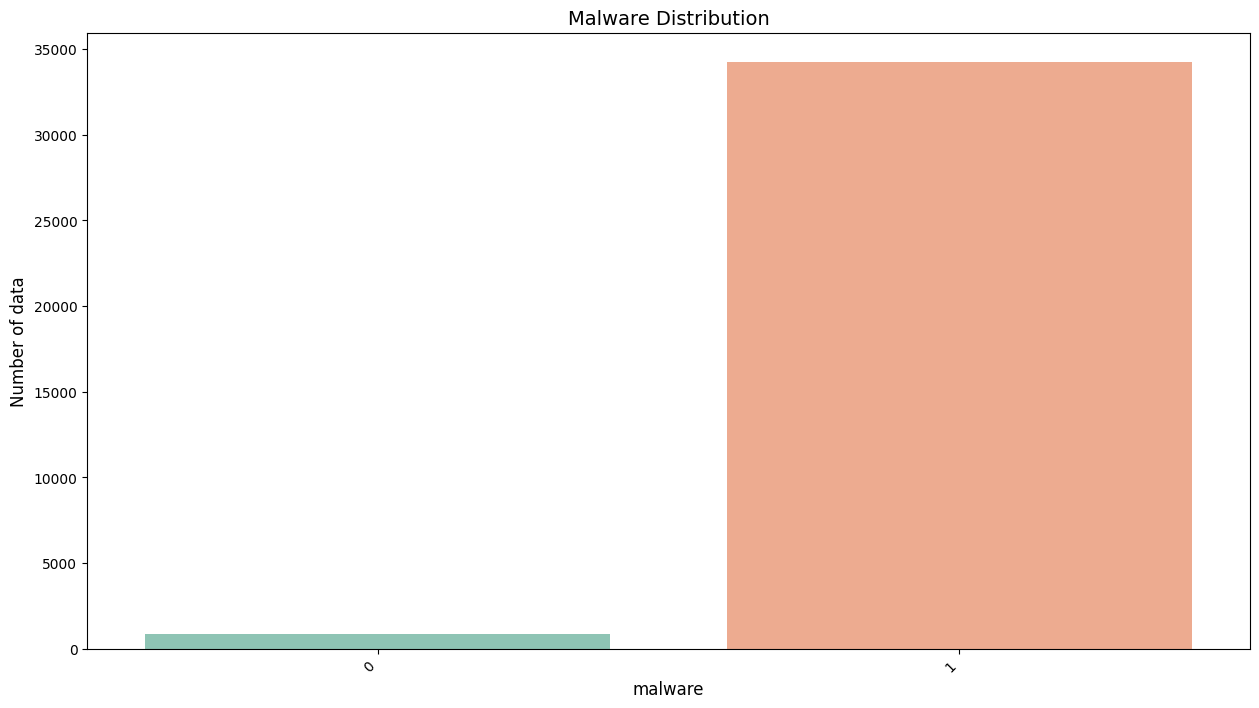

In [12]:
cnt_pro = train['malware'].value_counts()

plt.figure(figsize=(15,8))
# Assign the barplot to an axes object 'ax'
ax = sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8, palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.ylabel('Number of data', fontsize=12)
plt.xlabel('malware', fontsize=12)
# Remove the duplicate plt.xticks(rotation=90) as ax.set_xticklabels handles rotation
# plt.xticks(rotation=90)
plt.title('Malware Distribution', fontsize=14)
plt.show()

# Feature Engineer

## Split into features and trarget label

In [13]:
x_train = train.drop('malware', axis=1) 
y_train = train['malware'] 
x_test = test.drop('malware', axis=1) 
y_test = test['malware'] 

# Print the shapes of the resulting sets
print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (35100, 100)
y_train shape: (35100,)
X_test shape: (8776, 100)
y_test shape: (8776,)


## Normalization

In [14]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
x_train_std = scaler.fit_transform(x_train)
# Transform the test data using the fitted scaler
x_test_std = scaler.transform(x_test)

In [15]:
# Convert the scaled data back to DataFrames
x_train_std = pd.DataFrame(x_train_std, columns=x_train.columns)
x_test_std = pd.DataFrame(x_test_std, columns=x_test.columns)
x_train_std.describe()

t_0           t_1           t_2           t_3           t_4  \
count  3.510000e+04  3.510000e+04  3.510000e+04  3.510000e+04  3.510000e+04   
mean  -1.530400e-16 -1.220676e-16 -2.702492e-16 -1.805710e-16 -1.781418e-17   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00   
min   -1.862269e+00 -3.470570e+00 -3.065186e+00 -2.733193e+00 -2.630257e+00   
25%   -8.040650e-01 -6.510567e-01 -6.541849e-01 -1.050861e+00 -9.882581e-01   
50%   -8.040650e-01  4.767487e-01  2.053893e-01  3.827780e-01 -2.163783e-01   
75%    9.551998e-01  4.767487e-01  4.989025e-01  7.485023e-01  1.215108e+00   
max    2.158907e+00  1.571383e+00  3.308243e+00  1.714014e+00  1.664202e+00   

                t_5           t_6           t_7           t_8           t_9  \
count  3.510000e+04  3.510000e+04  3.510000e+04  3.510000e+04  3.510000e+04   
mean  -6.498126e-17  7.530538e-17  8.502221e-18 -1.064802e-16  2.206529e-17   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00   
min   -2.648494e+00 -3.068486e+00 -3.007622e+00 -2.137860e+00 -3.093614e+00   
25%   -8.687154e-01 -9.613328e-01 -6.112353e-01 -3.863419e-01 -9.417027e-01   
50%   -2.450323e-01  2.920932e-02  2.435267e-01 -3.863419e-01  8.747213e-02   
75%    1.002334e+00  8.036331e-01  6.251169e-01  9.759502e-01  7.611139e-01   
max    2.006311e+00  2.442530e+00  1.632515e+00  2.443034e+00  2.594916e+00   

       ...          t_90          t_91          t_92          t_93  \
count  ...  3.510000e+04  3.510000e+04  3.510000e+04  3.510000e+04   
mean   ...  3.623566e-17  1.651860e-16  2.753100e-17 -1.615422e-16   
std    ...  1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00   
min    ... -1.988217e+00 -1.969644e+00 -2.092740e+00 -2.154170e+00   
25%    ... -5.210352e-01 -9.350384e-01 -6.787004e-01 -6.150960e-01   
50%    ... -6.894509e-03 -1.686636e-01 -1.398097e-02 -2.505786e-01   
75%    ...  1.021387e+00  1.095855e+00  1.049570e+00  1.085986e+00   
max    ...  1.849028e+00  1.938867e+00  1.605517e+00  1.977028e+00   

               t_94          t_95          t_96          t_97          t_98  \
count  3.510000e+04  3.510000e+04  3.510000e+04  3.510000e+04  3.510000e+04   
mean   1.595179e-16  2.200456e-16  1.388696e-16  1.046583e-16  2.672127e-17   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00   
min   -2.345042e+00 -2.459406e+00 -1.906935e+00 -2.029966e+00 -2.138000e+00   
25%   -6.812561e-01 -8.005519e-01 -7.931117e-01 -7.483795e-01 -6.984123e-01   
50%    8.664514e-02 -2.074870e-02 -1.423383e-01  1.615471e-01 -5.859557e-02   
75%    7.123424e-01  9.433716e-01  7.837623e-01  8.407881e-01  8.611411e-01   
max    2.006398e+00  1.879135e+00  1.922616e+00  1.891689e+00  1.940832e+00   

               t_99  
count  3.510000e+04  
mean  -2.186285e-17  
std    1.000014e+00  
min   -1.972789e+00  
25%   -1.048133e+00  
50%   -1.868092e-01  
75%    8.771786e-01  
max    1.903167e+00  

[8 rows x 100 columns]

## Dimensionality Reduction

In [16]:
# --- Apply PCA for dimensionality reduction ---
# Initialize PCA with the desired number of components.  For example, to reduce to 2 dimensions
pca = PCA(n_components=2) # You can change n_components as needed
# Fit PCA on the scaled training data and transform it.
x_train = pca.fit_transform(x_train_std)
# Transform the scaled test data using the fitted PCA.
x_test = pca.transform(x_test_std)

## Visualize the PCA-transformed data

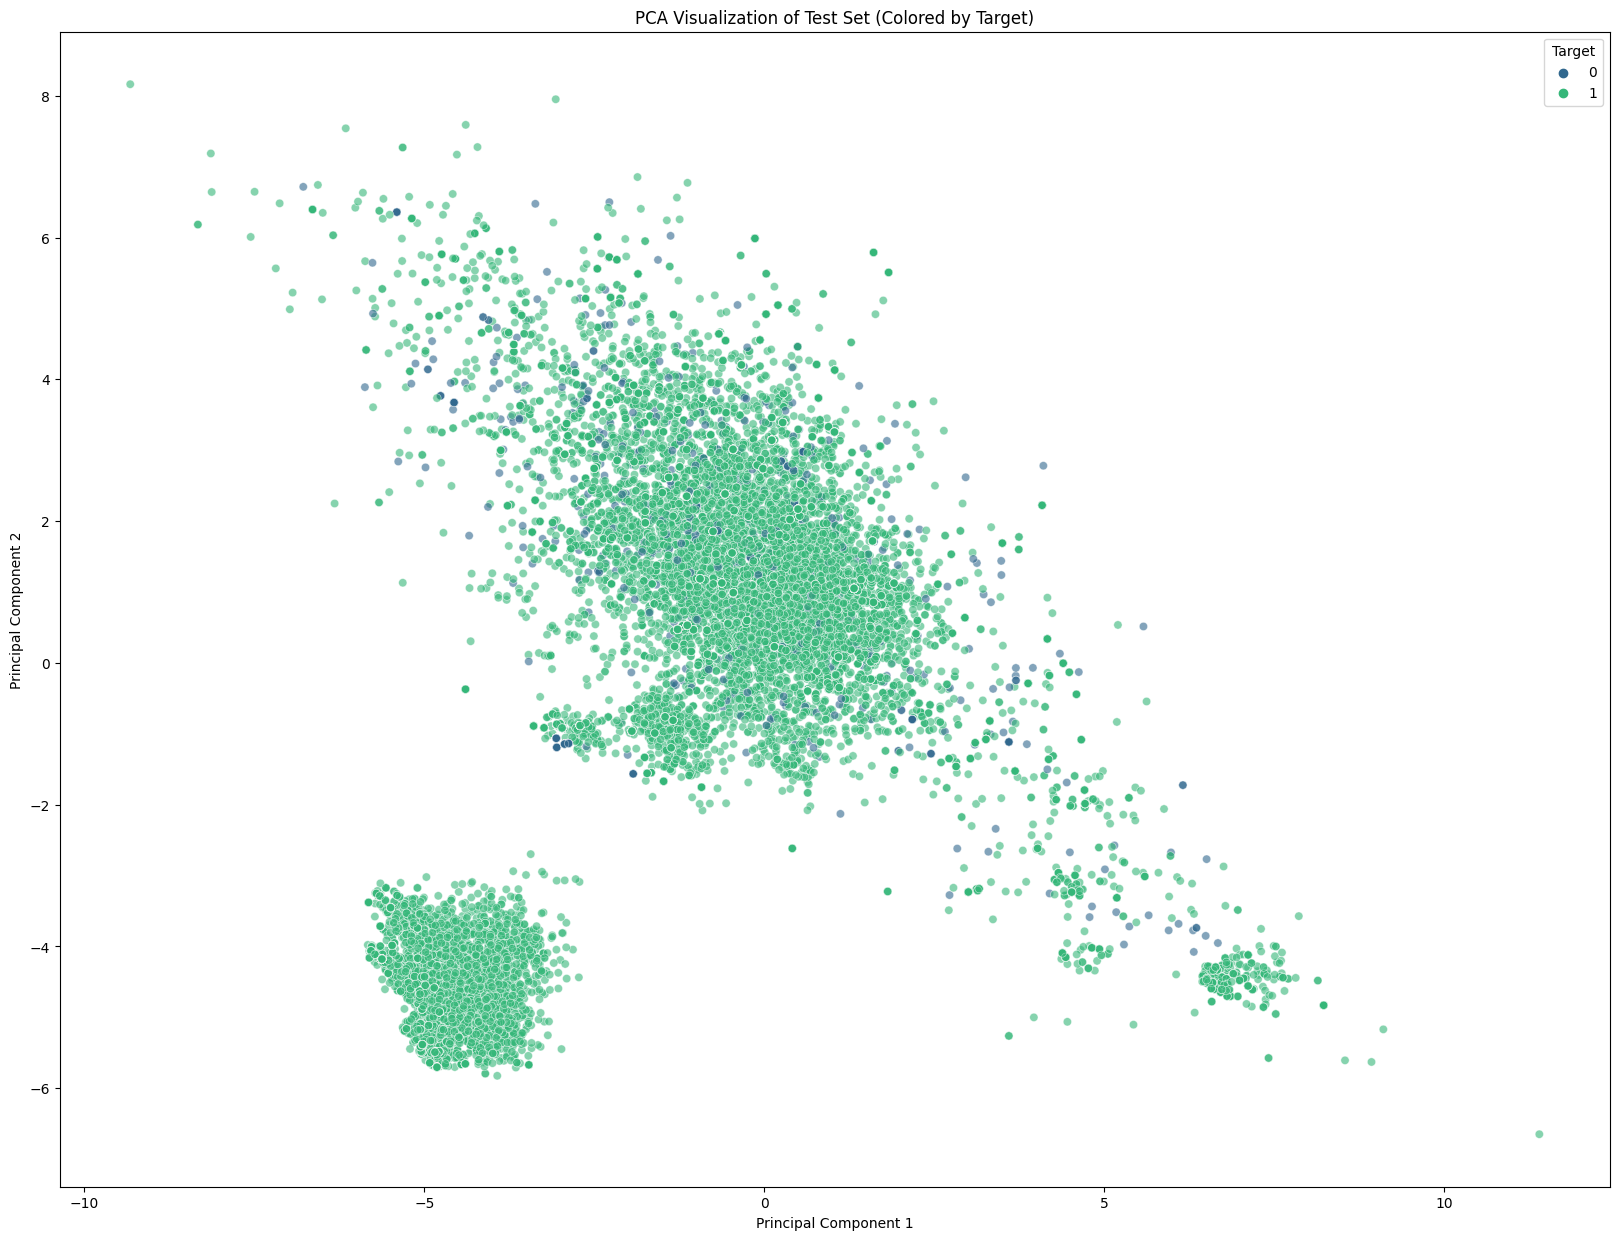

In [17]:
# --- Visualize the PCA-transformed data ---

# Create a DataFrame for the test set PCA components
plot_data = pd.DataFrame({
    'PC1': x_train[:, 0],  # First principal component
    'PC2': x_train[:, 1],  # Second principal component
    'Target': y_train         # Target variable for coloring
})

# Create the scatter plot
plt.figure(figsize=(20, 15))
sns.scatterplot(
    data=plot_data,
    x="PC1",
    y="PC2",
    hue="Target",  # Color by target variable (e.g., charges)
    palette="viridis",  # Continuous palette for charges
    alpha=0.6  # Slight transparency for overlapping points
)

# Set labels and title
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Test Set (Colored by Target)")

# Optionally add a regression line (if desired)
# sns.regplot(data=plot_data, x="PC1", y="PC2", scatter=False, color="blue")

# Show the plot
plt.show()

## Oversampling

In [18]:
smote = SMOTE(random_state=42)
print("Shape of original x_train:", x_train.shape)
print("Shape of original y_train:", y_train.shape)
x_train, y_train = smote.fit_resample(x_train, y_train)
# Print the shapes of the original and resampled data to see the effect
print("Shape of original x_train:", x_train.shape)
print("Shape of original y_train:", y_train.shape)
y_train.value_counts(normalize=True)*100

Shape of original x_train: (35100, 2)
Shape of original y_train: (35100,)
Shape of original x_train: (68494, 2)
Shape of original y_train: (68494,)


malware
1    50.0
0    50.0
Name: proportion, dtype: float64

## Visualize the PCA-transformed data after oversampling

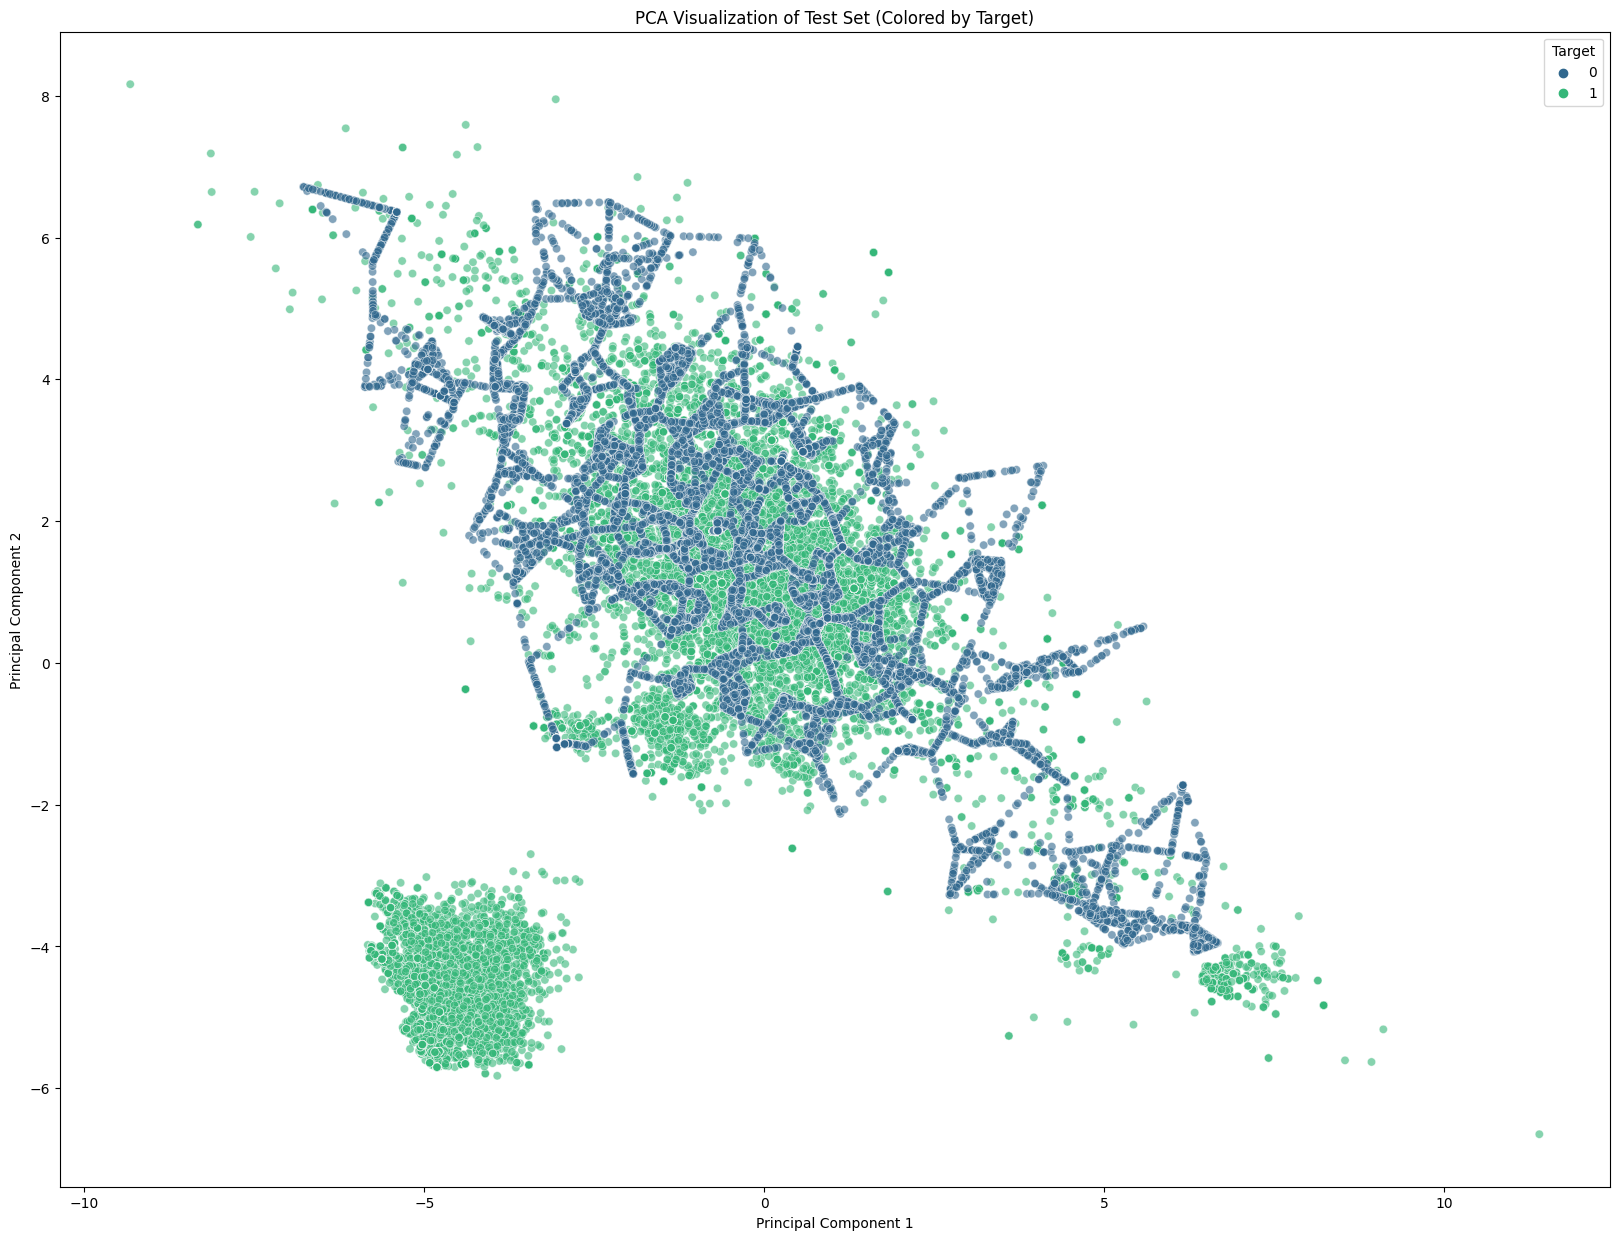

In [19]:
# --- Visualize the PCA-transformed data ---

# Create a DataFrame for the test set PCA components
plot_data = pd.DataFrame({
    'PC1': x_train[:, 0],  # First principal component
    'PC2': x_train[:, 1],  # Second principal component
    'Target': y_train         # Target variable for coloring
})

# Create the scatter plot
plt.figure(figsize=(20, 15))
sns.scatterplot(
    data=plot_data,
    x="PC1",
    y="PC2",
    hue="Target",  # Color by target variable (e.g., charges)
    palette="viridis",  # Continuous palette for charges
    alpha=0.6  # Slight transparency for overlapping points
)

# Set labels and title
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Test Set (Colored by Target)")

# Optionally add a regression line (if desired)
# sns.regplot(data=plot_data, x="PC1", y="PC2", scatter=False, color="blue")

# Show the plot
plt.show()

# Modeling and Experiments

## Model Architecture, model building (Keras), and model training

In [20]:
# --- Build the Multi-Layer Perceptron (MLP) Model using Keras Sequential API ---
# An MLP consists of multiple layers, including at least one hidden layer.
# add a hidden Dense layer with a ReLU activation before the output layer.

model = keras.Sequential([
    # Input layer implicitly defined by the shape of the first data point.
    # First Dense layer (hidden layer) with, for example, 64 neurons and ReLU activation.
    layers.Dense(64, input_shape=(x_train.shape[1],), activation='relu', name='hidden_layer'),
    layers.Dense(64, input_shape=(x_train.shape[1],), activation='relu', name='hidden_layer_1'),
    # Output Dense layer with 1 neuron and sigmoid activation for binary classification.
    layers.Dense(1, activation='sigmoid', name='output_layer')
])

# --- Compile the Model ---
# For binary classification, 'binary_crossentropy' is a suitable loss function.
# 'adam' is a good general-purpose optimizer.
# 'accuracy' is the metric we want to monitor during training.
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# --- Train the Model ---
# train the model for a few epochs.
# 'verbose=1' will show training progress.

# Define EarlyStopping callback
# It monitors 'val_loss' (validation loss)
# 'patience=10' means it will stop if validation loss doesn't improve for 10 consecutive epochs
# 'restore_best_weights=True' ensures the model loads the weights from the epoch with the best monitored quantity
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(x_train, y_train, epochs=200, verbose=1, validation_split=0.2, callbacks=[early_stopping]) # Use validation_split for monitoring and pass the callback

print("\nTraining complete.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-22 16:34:48.454771: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer (Dense)            │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6447 - loss: 0.5985 - val_accuracy: 0.5242 - val_loss: 0.7514
Epoch 2/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7071 - loss: 0.5313 - val_accuracy: 0.5254 - val_loss: 0.7186
Epoch 3/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7086 - loss: 0.5192 - val_accuracy: 0.4974 - val_loss: 0.7263
Epoch 4/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7174 - loss: 0.5111 - val_accuracy: 0.5235 - val_loss: 0.6743
Epoch 5/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7258 - loss: 0.5080 - val_accuracy: 0.5024 - val_loss: 0.6972
Epoch 6/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7243 - loss: 0.5027 - val_accuracy: 0.4808 - val_loss: 0.7132
Epoch 7/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7281 - loss: 0.4972 - val_accuracy: 0.4759 - val_loss: 0.7114
Epoch 8/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7233 - loss: 0

## Visualize Model Training (Training loss and Model accuracy during training)

Final Training Loss: 0.4026
Final Training Accuracy: 0.7656

Learned Weights (Output Layer): [ 0.09795768 -1.6858242  -0.03030532 ...  0.03290049  0.23341933
  0.340862  ]
Learned Bias (Output Layer): 0.2382
2141/2141 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step

Sample Predictions (from training data):
  Input: [ 8.22433298 -4.82968474], Actual: 1, Predicted (proba): 0.9969, Predicted (binary): 1
  Input: [0.12432161 0.8807271 ], Actual: 1, Predicted (proba): 0.7309, Predicted (binary): 1
  Input: [ 8.22433298 -4.82968474], Actual: 1, Predicted (proba): 0.9969, Predicted (binary): 1
  Input: [0.15724433 0.27817579], Actual: 1, Predicted (proba): 0.7604, Predicted (binary): 1
  Input: [1.31936059 1.05192443], Actual: 1, Predicted (proba): 0.8703, Predicted (binary): 1
  Input: [-1.57739295  3.20050736], Actual: 1, Predicted (proba): 0.5117, Predicted (binary): 1
  Input: [-0.78755711  3.2183103 ], Actual: 1, Predicted (proba): 0.5225, Predicted (binary): 1
  Input: [-1.85247027  3.80433916], Act

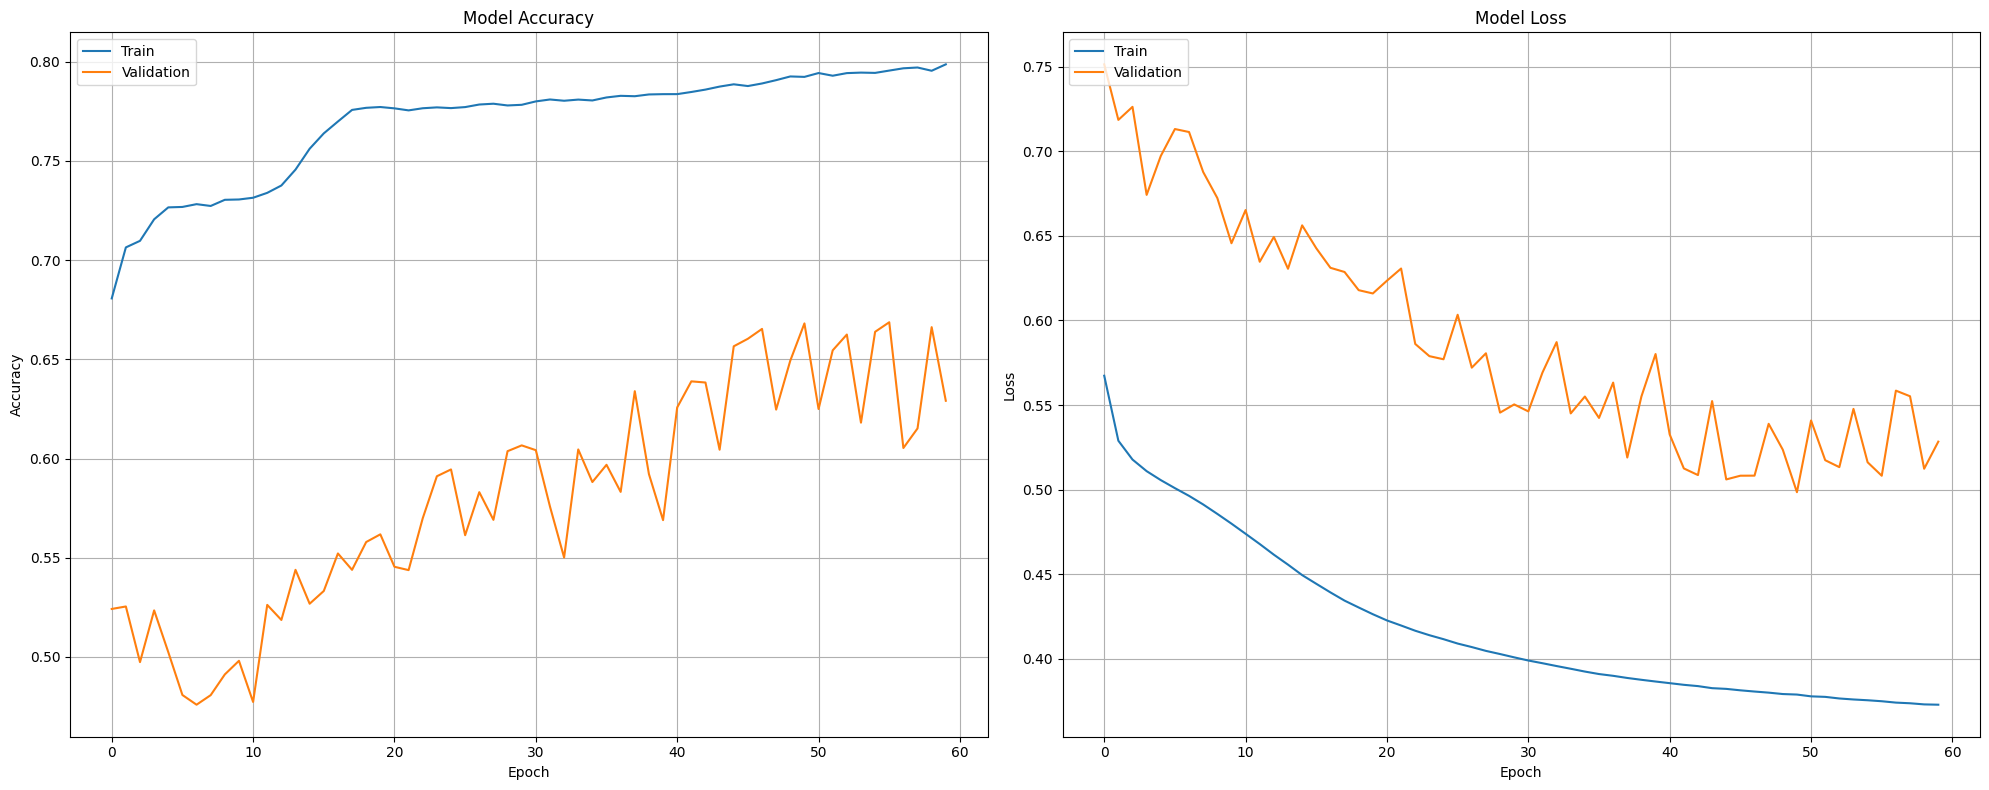

In [21]:
# --- Evaluate the Model ---
# Evaluate the model on the training data
loss, accuracy = model.evaluate(x_train, y_train, verbose=0)
print(f"Final Training Loss: {loss:.4f}")
print(f"Final Training Accuracy: {accuracy:.4f}")

# --- Make Predictions ---
# Get the learned weights and bias from the output layer (model.layers[1] for MLP)
# Note: For MLP, 'learned weights' typically refers to all weights, but for simplicity
# and comparison with Perceptron, we'll show the output layer's weights.
weights, bias = model.layers[1].get_weights() # Access the output layer's weights and bias
print(f"\nLearned Weights (Output Layer): {weights.flatten()}")
print(f"Learned Bias (Output Layer): {bias[0]:.4f}")

# Predict probabilities on the training data
y_pred_proba = model.predict(x_train).flatten()
# Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nSample Predictions (from training data):")
for i in range(min(10, len(x_train))): # Ensure we don't go out of bounds
    print(f"  Input: {x_train[i]}, Actual: {y_train[i]}, Predicted (proba): {y_pred_proba[i]:.4f}, Predicted (binary): {y_pred[i]}")

# --- Visualize the Loss and Accuracy during Training ---
plt.figure(figsize=(20, 8))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

## Visualize the Decision Boundary 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


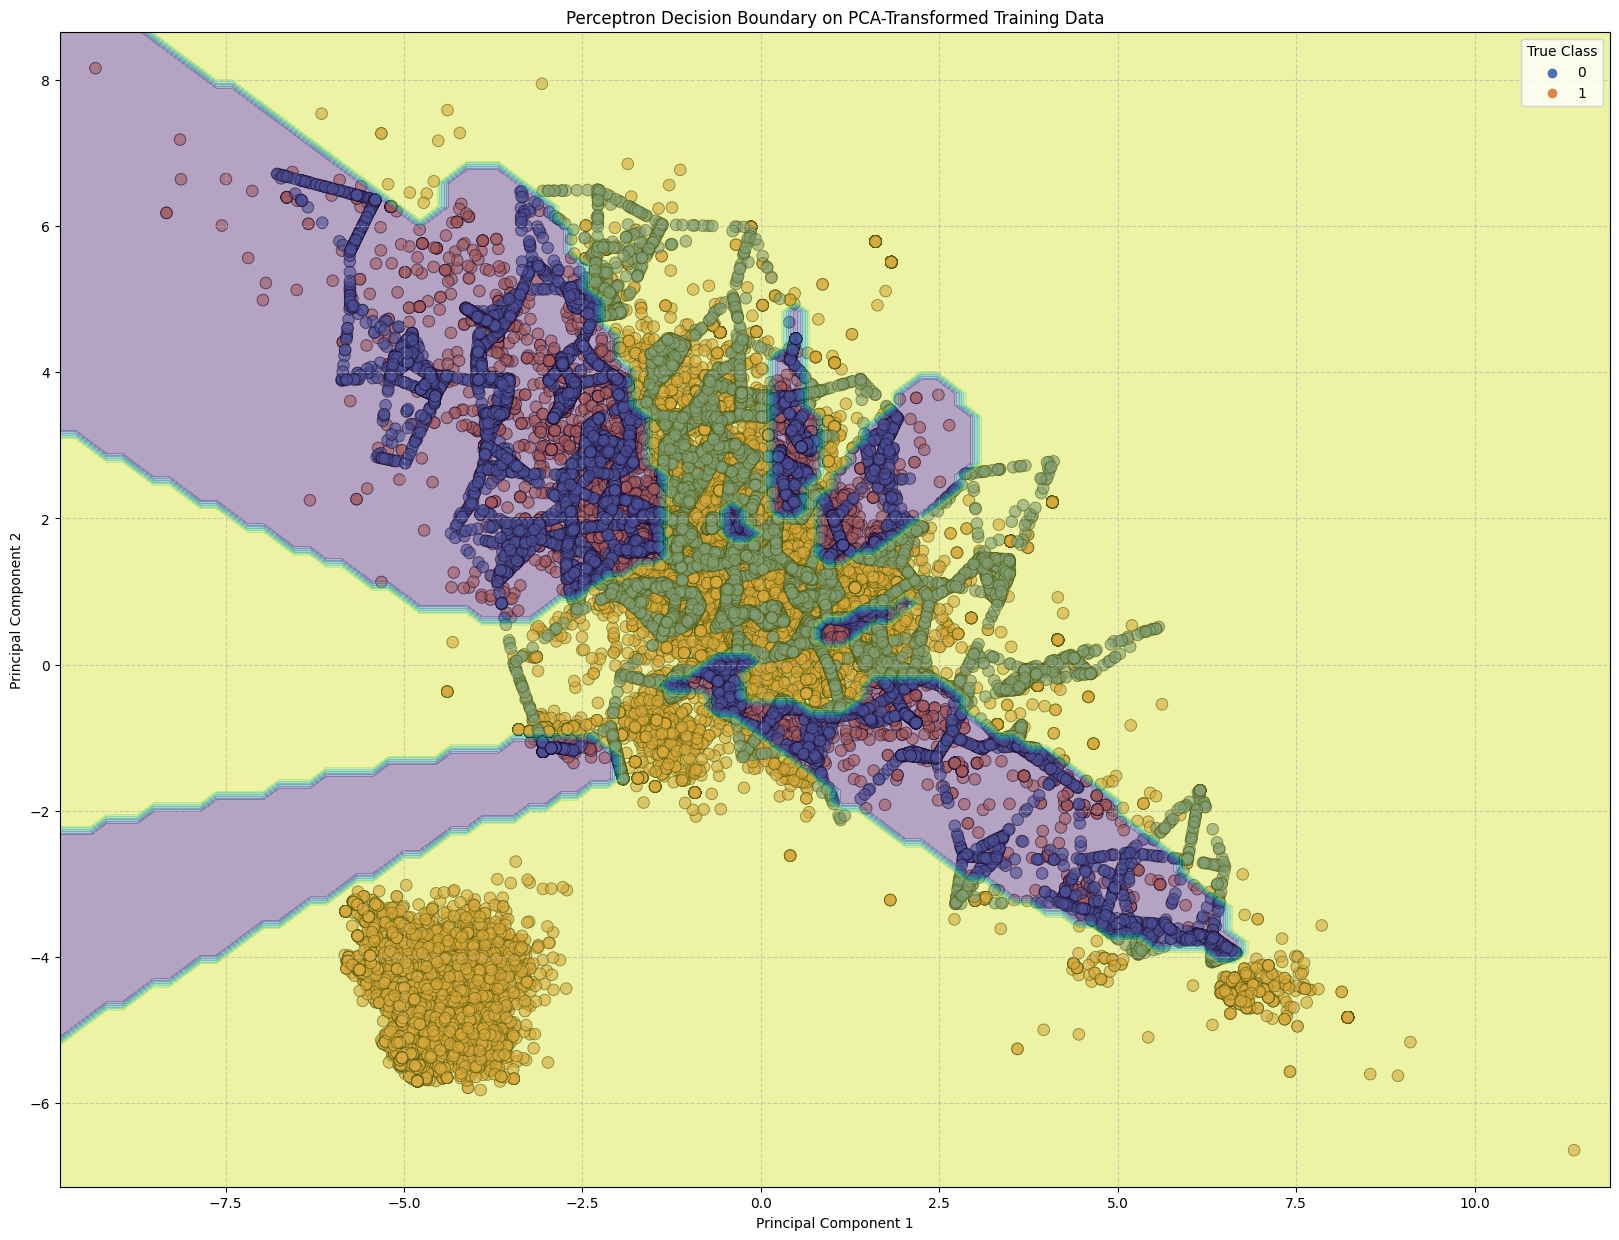

In [22]:
# --- Visualize the Decision Boundary of the Perceptron ---

# Create a DataFrame for the PCA-transformed training components for plotting
plot_data_train = pd.DataFrame({
    'PC1': x_train[:, 0],
    'PC2': x_train[:, 1],
    'Target': y_train
})

# Create the scatter plot with the specified figure size
plt.figure(figsize=(20, 15)) # Increased figure size as requested
sns.scatterplot(
    data=plot_data_train,
    x="PC1",
    y="PC2",
    hue="Target",
    palette="deep",
    alpha=0.6, # Alpha as requested
    edgecolor='k', # Add black edges to points for better visibility
    s=70 # Size of the points
)

# Create a meshgrid to plot the decision boundary
x_min, x_max = x_train[:, 0].min() - 0.5, x_train[:, 0].max() + 0.5
y_min, y_max = x_train[:, 1].min() - 0.5, x_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Predict class for each point in the meshgrid using the Keras model
# Keras model.predict returns probabilities, so we need to threshold them
Z_proba = model.predict(np.c_[xx.ravel(), yy.ravel()], verbose=1).flatten()
Z = (Z_proba > 0.5).astype(int) # Threshold to get binary classes
Z = Z.reshape(xx.shape)

# Plot the decision boundary as a filled contour
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.viridis)


# Set labels and title
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Perceptron Decision Boundary on PCA-Transformed Training Data")
plt.legend(title="True Class")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Model Architecture, model building (tensflow custom layer), and model training

In [23]:
# --- Custom Layer Definition ---
# A custom layer inherits from tf.keras.layers.Layer
class CustomDenseLayer(layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(CustomDenseLayer, self).__init__(**kwargs)
        self.units = units # Number of neurons in the layer
        self.activation = keras.activations.get(activation) # Get the activation function

    def build(self, input_shape):
        # This method is called once the layer knows the shape of its inputs.
        # It's used to create the layer's weights.
        # 'input_shape' is a tf.TensorShape object.
        self.kernel = self.add_weight(
            name='kernel',
            shape=(input_shape[-1], self.units), # Weights connecting input features to neurons
            initializer='glorot_uniform', # Common initializer for Dense layers
            trainable=True # These weights should be updated during training
        )
        self.bias = self.add_weight(
            name='bias',
            shape=(self.units,), # Bias for each neuron
            initializer='zeros', # Common initializer for bias
            trainable=True # These biases should be updated during training
        )
        super(CustomDenseLayer, self).build(input_shape) # Call the super build method

    def call(self, inputs):
        # This method defines the layer's forward pass logic.
        # It describes how the layer processes its input and produces its output.
        # The operation is: inputs * weights + bias
        output = tf.matmul(inputs, self.kernel) + self.bias
        if self.activation is not None:
            output = self.activation(output) # Apply activation if specified
        return output

    def get_config(self):
        # This method is important for serialization (saving/loading the model).
        # It returns a dictionary containing the configuration of the layer.
        config = super(CustomDenseLayer, self).get_config()
        config.update({
            'units': self.units,
            'activation': keras.activations.serialize(self.activation)
        })
        return config

# --- Build the Multi-Layer Perceptron (MLP) Model using Keras Sequential API with Custom Layer ---
model = keras.Sequential([
    # Input layer implicitly defined by the shape of the first data point.
    # First CustomDenseLayer (hidden layer) with 64 neurons and ReLU activation.
    CustomDenseLayer(64, activation='relu', name='custom_hidden_layer_1'),
    # Second CustomDenseLayer (hidden layer) with 64 neurons and ReLU activation.
    CustomDenseLayer(64, activation='relu', name='custom_hidden_layer_2'),
    # Output CustomDenseLayer with 1 neuron and sigmoid activation for binary classification.
    CustomDenseLayer(1, activation='sigmoid', name='custom_output_layer')
])

# --- Compile the Model ---
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# --- Train the Model ---
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

print("\nStarting training...")
history = model.fit(x_train, y_train, epochs=200, verbose=1, validation_split=0.2, callbacks=[early_stopping])

print("\nTraining complete.")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_hidden_layer_1           │ ?                      │   0 (unbuilt) │
│ (CustomDenseLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_hidden_layer_2           │ ?                      │   0 (unbuilt) │
│ (CustomDenseLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_output_layer             │ ?                      │   0 (unbuilt) │
│ (CustomDenseLayer)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Starting training...
Epoch 1/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6535 - loss: 0.5778 - val_accuracy: 0.5341 - val_loss: 0.7245
Epoch 2/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7057 - loss: 0.5258 - val_accuracy: 0.5124 - val_loss: 0.7196
Epoch 3/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7124 - loss: 0.5136 - val_accuracy: 0.5252 - val_loss: 0.6829
Epoch 4/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7203 - loss: 0.5104 - val_accuracy: 0.5157 - val_loss: 0.6833
Epoch 5/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7256 - loss: 0.5029 - val_accuracy: 0.4924 - val_loss: 0.6974
Epoch 6/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7283 - loss: 0.4988 - val_accuracy: 0.5070 - val_loss: 0.6728
Epoch 7/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7275 - loss: 0.4953 - val_accuracy: 0.4678 - val_loss: 0.6957
Epoch 8/200
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accu

## Visualize Model Training (Training loss and Model accuracy during training)

Final Training Loss: 0.3866
Final Training Accuracy: 0.7872

Learned Weights (Output Layer): [-0.168706    0.14883512  0.25000426 ... -0.21964867 -0.11713497
 -0.07127016]
Learned Bias (Output Layer): -0.1393
2141/2141 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Sample Predictions (from training data):
  Input: [ 8.22433298 -4.82968474], Actual: 1, Predicted (proba): 0.9988, Predicted (binary): 1
  Input: [0.12432161 0.8807271 ], Actual: 1, Predicted (proba): 0.7578, Predicted (binary): 1
  Input: [ 8.22433298 -4.82968474], Actual: 1, Predicted (proba): 0.9988, Predicted (binary): 1
  Input: [0.15724433 0.27817579], Actual: 1, Predicted (proba): 0.6952, Predicted (binary): 1
  Input: [1.31936059 1.05192443], Actual: 1, Predicted (proba): 0.9306, Predicted (binary): 1
  Input: [-1.57739295  3.20050736], Actual: 1, Predicted (proba): 0.5056, Predicted (binary): 1
  Input: [-0.78755711  3.2183103 ], Actual: 1, Predicted (proba): 0.5592, Predicted (binary): 1
  Input: [-1.85247027  3.80433916], Actu

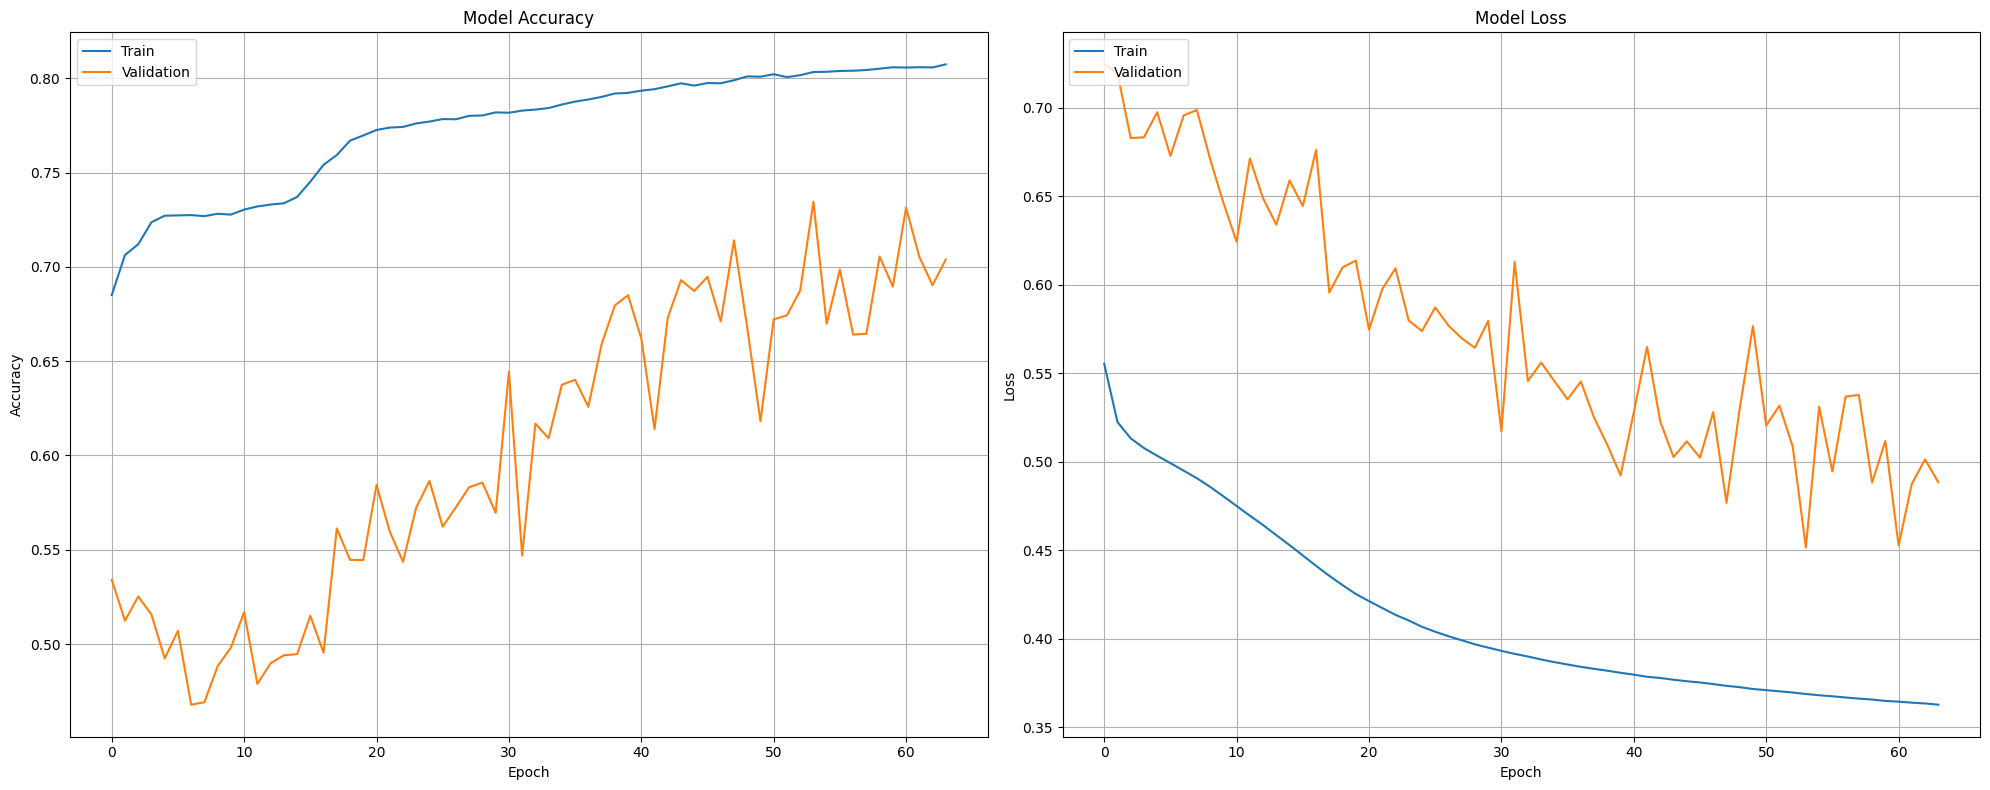

In [24]:
# --- Evaluate the Model ---
# Evaluate the model on the training data
loss, accuracy = model.evaluate(x_train, y_train, verbose=0)
print(f"Final Training Loss: {loss:.4f}")
print(f"Final Training Accuracy: {accuracy:.4f}")

# --- Make Predictions ---
# Get the learned weights and bias from the output layer (model.layers[1] for MLP)
# Note: For MLP, 'learned weights' typically refers to all weights, but for simplicity
# and comparison with Perceptron, we'll show the output layer's weights.
weights, bias = model.layers[1].get_weights() # Access the output layer's weights and bias
print(f"\nLearned Weights (Output Layer): {weights.flatten()}")
print(f"Learned Bias (Output Layer): {bias[0]:.4f}")

# Predict probabilities on the training data
y_pred_proba = model.predict(x_train).flatten()
# Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nSample Predictions (from training data):")
for i in range(min(10, len(x_train))): # Ensure we don't go out of bounds
    print(f"  Input: {x_train[i]}, Actual: {y_train[i]}, Predicted (proba): {y_pred_proba[i]:.4f}, Predicted (binary): {y_pred[i]}")

# --- Visualize the Loss and Accuracy during Training ---
plt.figure(figsize=(20, 8))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

## Visualize the Decision Boundary

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


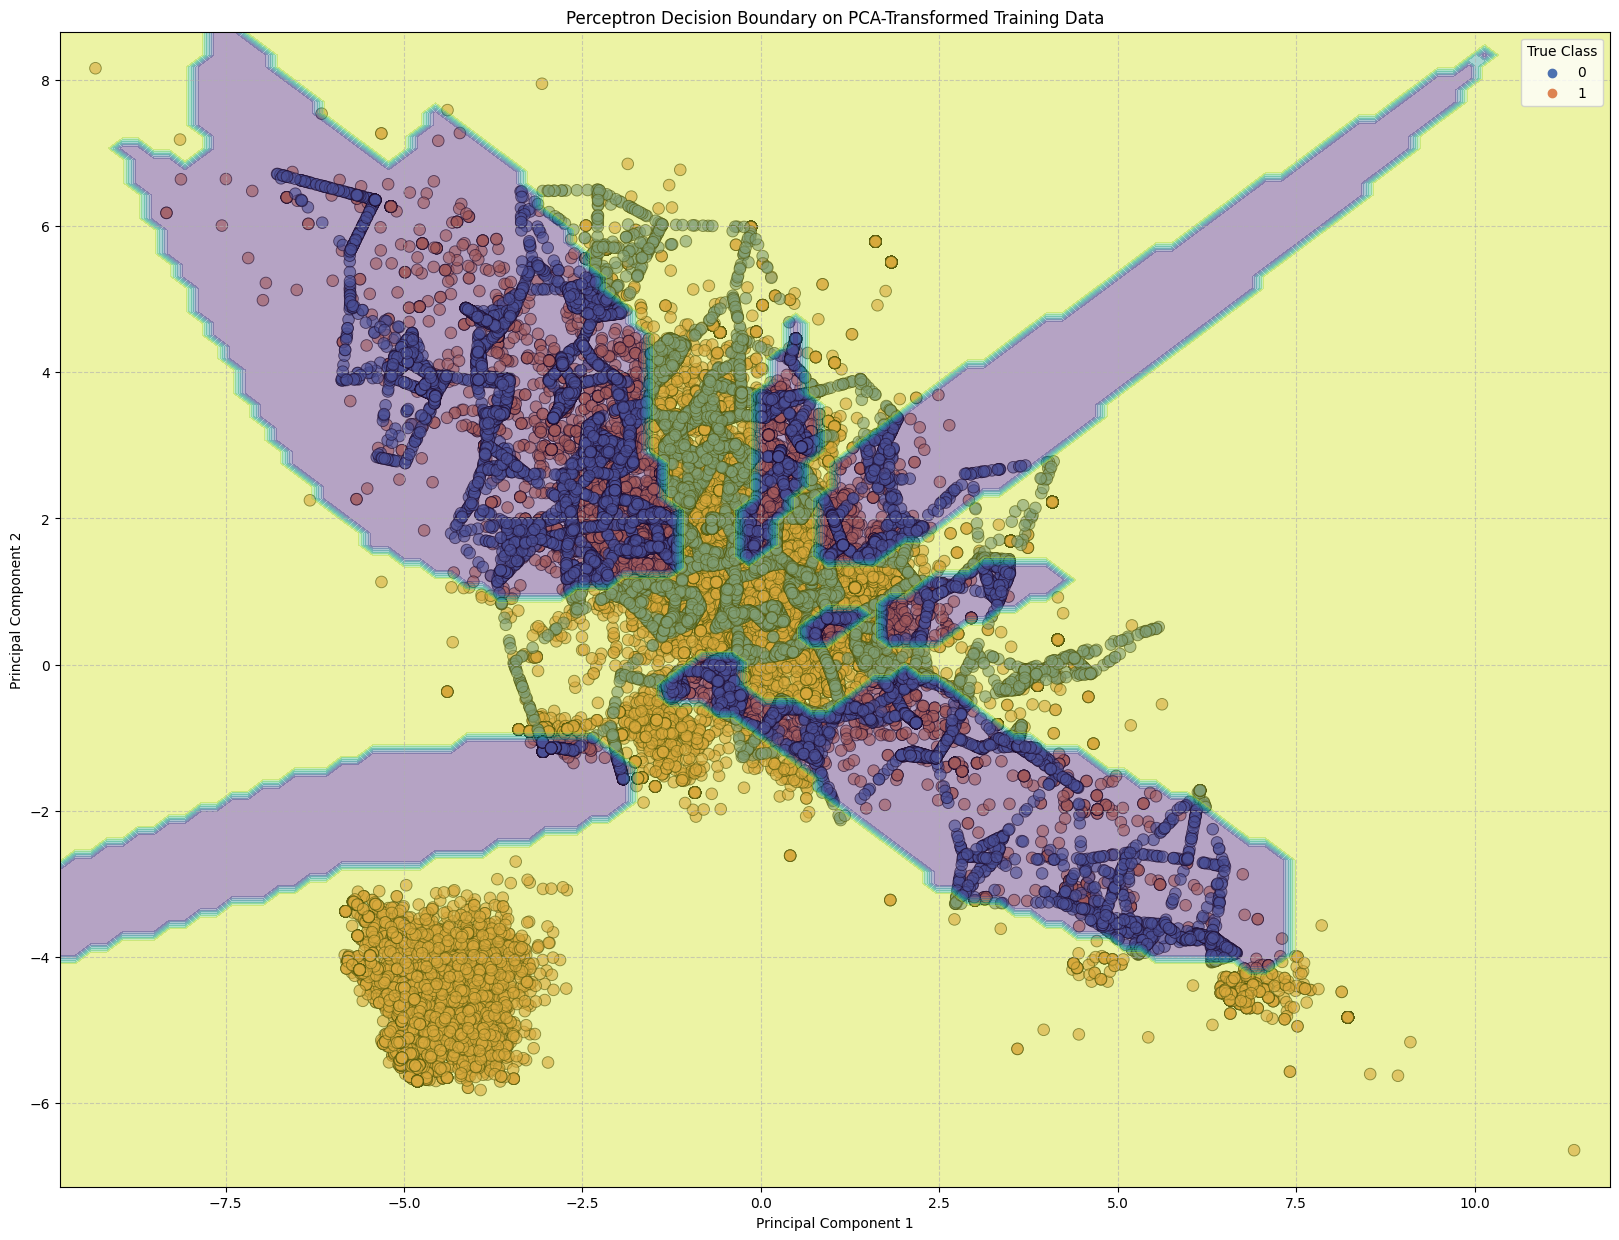

In [25]:
# --- Visualize the Decision Boundary of the Perceptron ---

# Create a DataFrame for the PCA-transformed training components for plotting
plot_data_train = pd.DataFrame({
    'PC1': x_train[:, 0],
    'PC2': x_train[:, 1],
    'Target': y_train
})

# Create the scatter plot with the specified figure size
plt.figure(figsize=(20, 15)) # Increased figure size as requested
sns.scatterplot(
    data=plot_data_train,
    x="PC1",
    y="PC2",
    hue="Target",
    palette="deep",
    alpha=0.6, # Alpha as requested
    edgecolor='k', # Add black edges to points for better visibility
    s=70 # Size of the points
)

# Create a meshgrid to plot the decision boundary
x_min, x_max = x_train[:, 0].min() - 0.5, x_train[:, 0].max() + 0.5
y_min, y_max = x_train[:, 1].min() - 0.5, x_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Predict class for each point in the meshgrid using the Keras model
# Keras model.predict returns probabilities, so we need to threshold them
Z_proba = model.predict(np.c_[xx.ravel(), yy.ravel()], verbose=1).flatten()
Z = (Z_proba > 0.5).astype(int) # Threshold to get binary classes
Z = Z.reshape(xx.shape)

# Plot the decision boundary as a filled contour
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.viridis)


# Set labels and title
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Perceptron Decision Boundary on PCA-Transformed Training Data")
plt.legend(title="True Class")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Model Evaluation

## Classification metrics and classification reports evaluation

In [26]:
# Make predictions on the scaled test data
# IMPORTANT: use x_test_pca for predictions as the model was trained on PCA-transformed data
y_pred_proba_test = model.predict(x_test, verbose=0).flatten()
y_pred_test = (y_pred_proba_test > 0.5).astype(int) # Convert probabilities to binary predictions

# Calculate metrics
cm = confusion_matrix(y_test, y_pred_test)
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred_test, average='macro', zero_division=1)
f1 = f1_score(y_test, y_pred_test, average='macro', zero_division=1)

# Calculate ROC-AUC for binary classification
# roc_auc_score expects probabilities or decision function scores.
# For Keras models, use the probabilities directly.
roc_auc = roc_auc_score(y_test, y_pred_proba_test)

# Print the results
print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"AUC-ROC: {roc_auc:.3f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, zero_division=1))

Confusion Matrix:
[[ 158   68]
 [1372 7178]]
Accuracy: 0.836
Precision: 0.547
Recall: 0.769
F1-score: 0.544
AUC-ROC: 0.880

Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.70      0.18       226
           1       0.99      0.84      0.91      8550

    accuracy                           0.84      8776
   macro avg       0.55      0.77      0.54      8776
weighted avg       0.97      0.84      0.89      8776



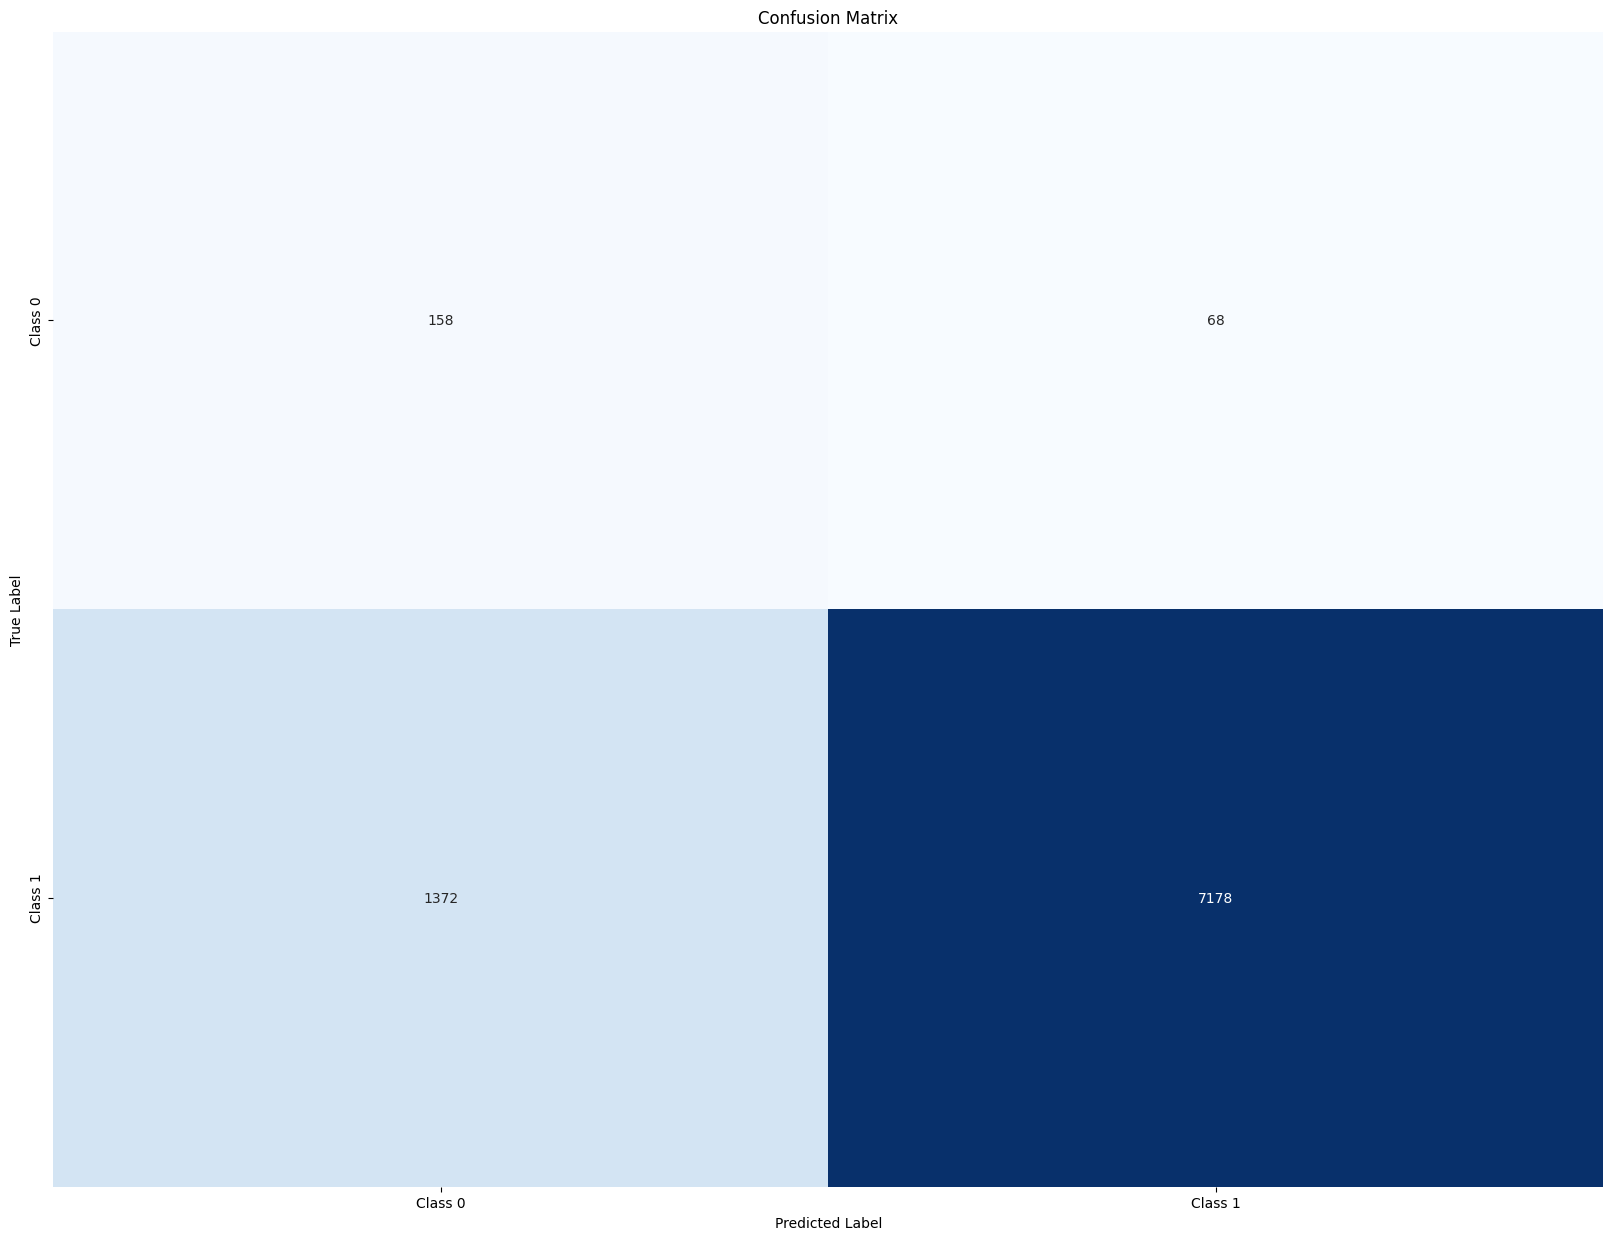

In [27]:
# --- Plotting Confusion Matrix ---
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Precision Recall Curve


--- Plotting Precision-Recall Curve ---
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


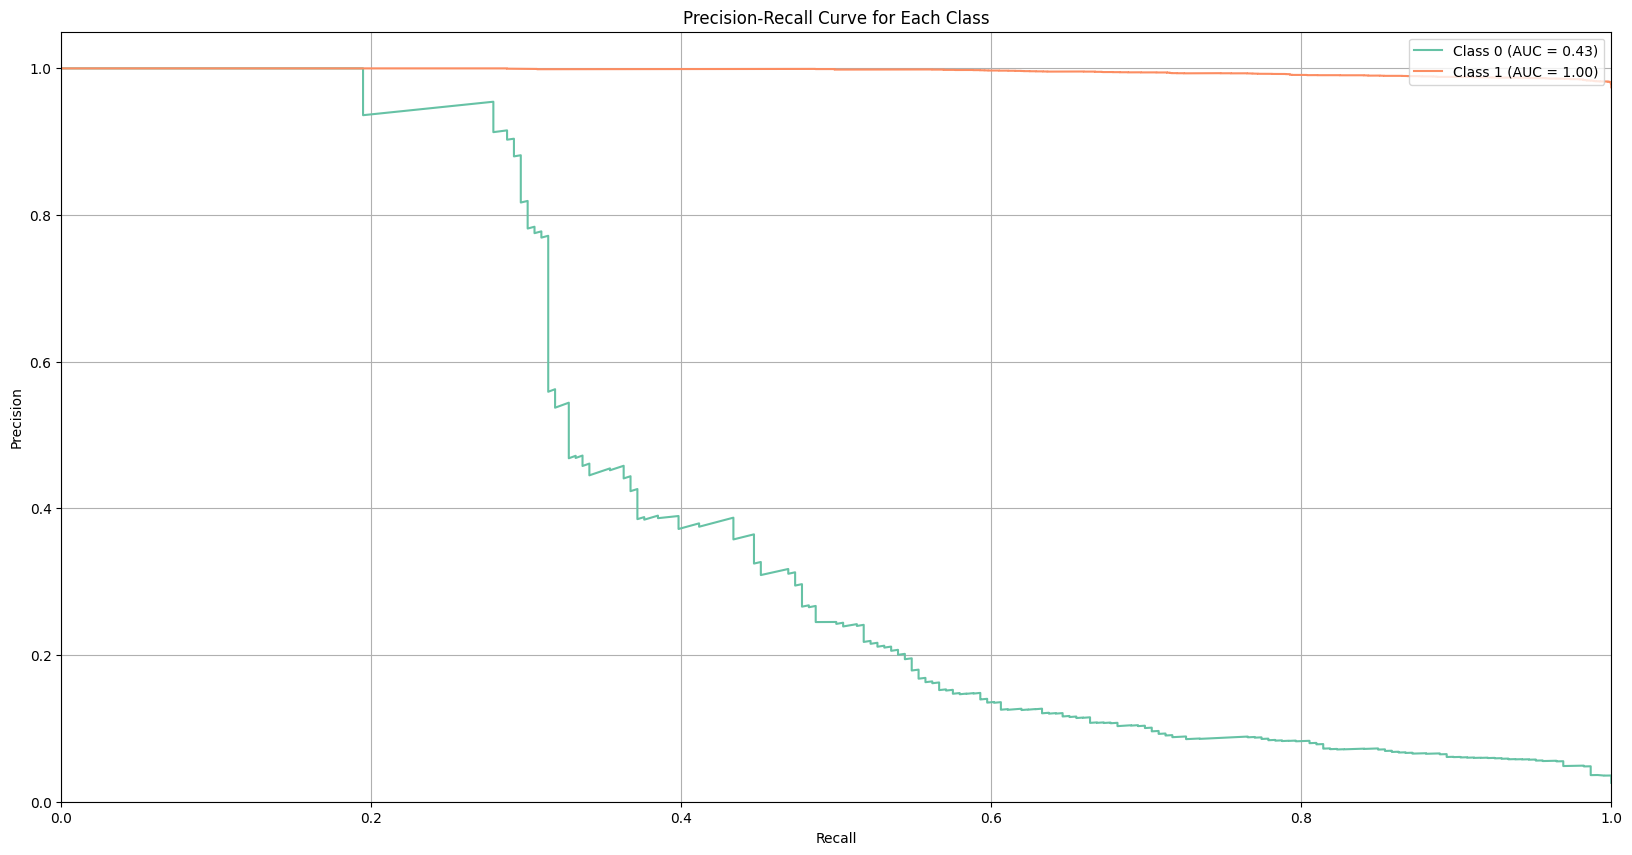

In [28]:
# --- Plotting Precision-Recall Curve ---
print("\n--- Plotting Precision-Recall Curve ---")

# Define class labels (for binary classification, 0 and 1)
class_labels = ["0", "1"]

# Initialize a plot
plt.figure(figsize=(20, 10))

# Set Seaborn color palette
sns.set_palette("Set2")

# Get the prediction probabilities for the test set
# For Keras models, model.predict() directly gives probabilities.
y_pred_proba_test_pr = model.predict(x_test, verbose=1).flatten()

# Generate Precision-Recall curve for each class
for i, label in enumerate(class_labels):
    # Get the true binary labels for the current class (OvR - One-vs-Rest)
    y_test_bin = np.where(y_test == int(label), 1, 0)

    # Determine the score for the current class
    # For a binary Keras Perceptron with sigmoid:
    # If plotting for class 1 (positive class), use probabilities directly.
    # If plotting for class 0 (negative class), use (1 - probabilities).
    if int(label) == 1:
        y_pred_score = y_pred_proba_test_pr
    else: # For class 0, use 1 - probabilities to represent confidence for class 0
        y_pred_score = 1 - y_pred_proba_test_pr

    # Compute Precision-Recall values
    precision, recall, _ = precision_recall_curve(y_test_bin, y_pred_score)
    # Calculate AUC for the Precision-Recall curve
    pr_auc = auc(recall, precision)

    # Plot the curve
    plt.plot(recall, precision, label=f'Class {label} (AUC = {pr_auc:.2f})')

# Add plot details
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend(loc="upper right")
plt.ylim([0, 1.05])
plt.xlim([0, 1])
plt.grid(True) # Add a grid for better readability

# Show the plot
plt.show()

## ROC AUC Curve


--- Plot ROC Curve for Label 0 and 1 ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

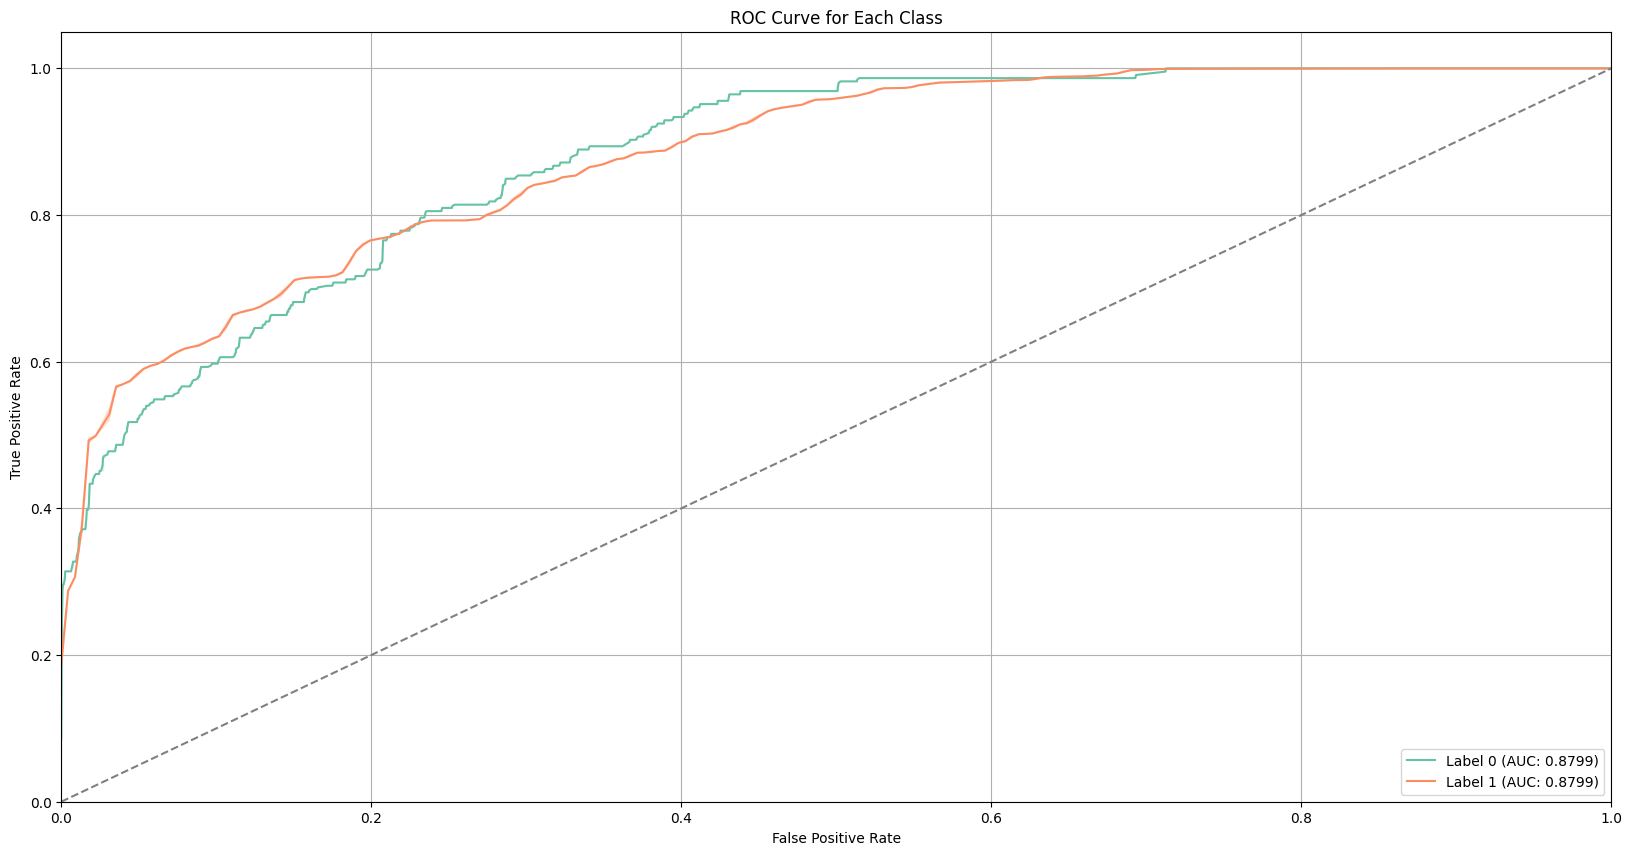


--- AUC ROC Values per Class ---
Label 0 AUC: 0.8799
Label 1 AUC: 0.8799
------------------------------


In [29]:
# --- Plot ROC Curve for Label 0 and 1 ---
print("\n--- Plot ROC Curve for Label 0 and 1 ---")

# Get prediction probabilities for the test set
# Keras models do not have 'decision_function'. Use 'predict' for probabilities.
y_pred_proba_roc = model.predict(x_test, verbose=0).flatten()

# Define class labels for plotting
class_labels_roc = ["Label 0", "Label 1"]
classes_roc = [0, 1]

# Initialize ROC curve and AUC dictionaries
fpr = dict()
tpr = dict()
roc_auc_per_class = dict() # Renamed to avoid conflict with roc_auc_val

# Create a new figure using Seaborn
plt.figure(figsize=(20, 10)) # Adjusted figure size for better readability

# Set Seaborn color palette
sns.set_palette("Set2")

# Loop over each class and calculate the ROC curve and AUC score
for i, class_val in enumerate(classes_roc):
    # For binary classification with Keras probabilities:
    # For label 1 (positive class), use y_test and y_pred_proba directly.
    # For label 0 (negative class), invert y_test (1-y_test) and use (1 - y_pred_proba).
    if class_val == 1: # For Label 1 (positive class)
        fpr[class_val], tpr[class_val], _ = roc_curve(y_test, y_pred_proba_roc)
    else: # For Label 0 (negative class)
        fpr[class_val], tpr[class_val], _ = roc_curve(1 - y_test, 1 - y_pred_proba_roc) # Invert true labels and probabilities

    # Calculate AUC
    roc_auc_per_class[class_val] = auc(fpr[class_val], tpr[class_val])

    # Plot ROC curve for each class
    sns.lineplot(x=fpr[class_val], y=tpr[class_val], label=f'{class_labels_roc[i]} (AUC: {roc_auc_per_class[class_val]:.4f})')

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.grid(True) # Add grid for better readability
# plt.savefig('roc_curve_per_class.png') # Saving to file might not be visible in all environments

# Show the plot
plt.show()

# Show AUC values for each class
print("\n--- AUC ROC Values per Class ---")
for class_val in classes_roc:
    print(f"{class_labels_roc[class_val]} AUC: {roc_auc_per_class[class_val]:.4f}")
print("-" * 30)

## Visualize Decision Boundary of the model on test dataset

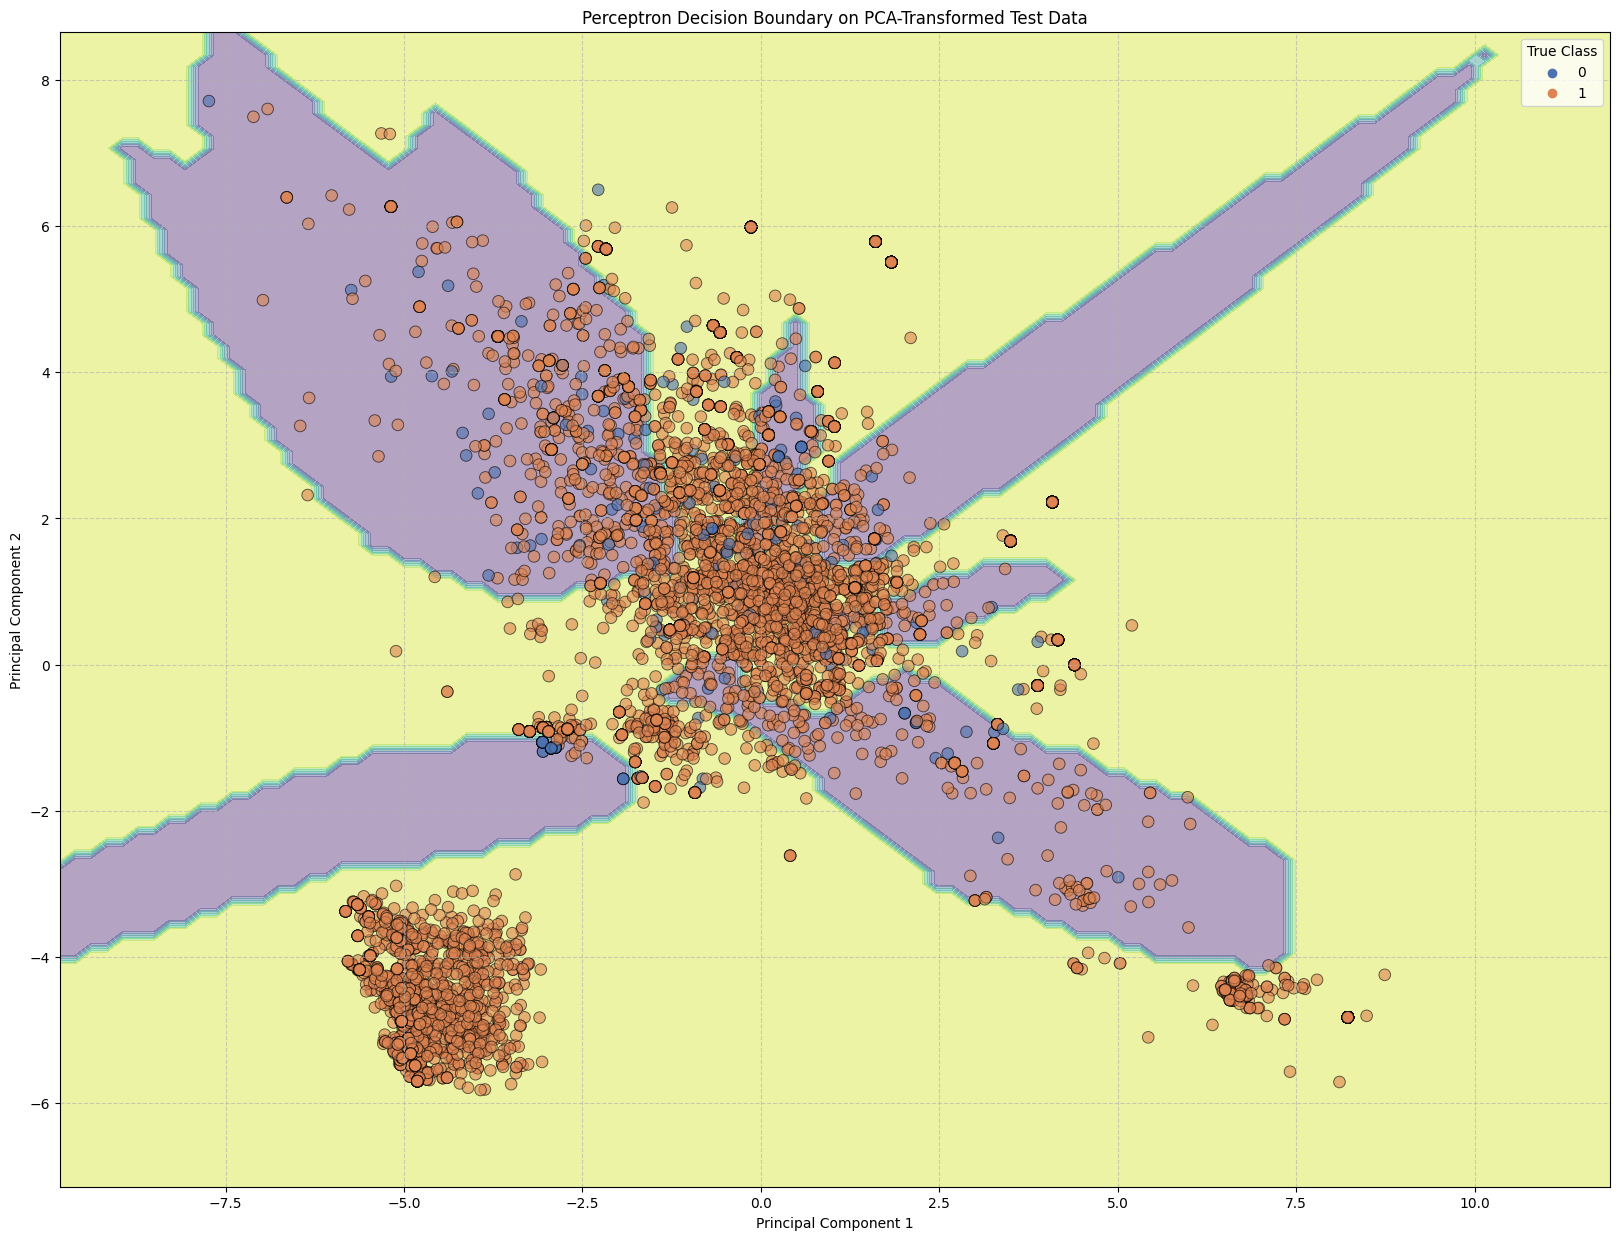

In [30]:
# --- Optional: Visualize test data on the same boundary ---
# how well the model generalizes.
plot_data_test = pd.DataFrame({
    'PC1': x_test[:, 0],
    'PC2': x_test[:, 1],
    'Target': y_test
})

plt.figure(figsize=(20, 15)) # Consistent figure size
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.viridis) # Plot the same decision regions

sns.scatterplot(
    data=plot_data_test,
    x="PC1",
    y="PC2",
    hue="Target",
    palette="deep",
    alpha=0.6, # Consistent alpha
    edgecolor='k',
    s=70
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Perceptron Decision Boundary on PCA-Transformed Test Data")
plt.legend(title="True Class")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()